<a href="https://colab.research.google.com/github/ns4lin4s/data_science/blob/master/analisis_request.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

**Análisis de peticiones al servidor**

El objetivo de este proyecto es entender porqué existen tantos cobros por exceso de uso de algunos endpoint. 

El sitio web se trata de un buscador de propiedades, el cual los clientes o usuarios pueden cotizar casas o departamentos.

* **Home**: Es la página principal, consta de un buscador de dirección
* **Mapa**: Es la página de resultado de la búsqueda, el cual despliega todas las casas o deptos.
* **Ficha**: Es la página de la casa con todas sus características.

Para entender el comportamiento de nuestros datos se contestarán las siguientes preguntas a lo largo del proyecto:

*   ¿Qué usuarios están realizando excesivas búsquedas?   
*   ¿Qué páginas suelen visitar?
*   ¿Cuantas peticiones realiza?
*   ¿La ip registrada alguna vez se ha logeado? 



### Ejecución del proyecto


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import numpy as np

In [2]:
import re
  
# Función para limpiar URL's
def clean_url(method):
    
    if re.search('/home/index', method):
        return 'pagina_inicio'
    elif re.search('/propiedades/compranuevo/casa/', method):
        return 'pagina_casa'
    elif re.search('/propiedades/compranuevo/casas/', method):
        return 'pagina_casa'
    elif re.search('/propiedades/compranuevo/departamento/', method):
        return 'pagina_depto'
    elif re.search('/resultados/mapa', method):
        return 'mapa'
    elif re.search('pautocomplete', method):
        return 'buscador'
    else:
        return method



In [3]:
#############################################################
# 1. Recuperar datos desde una fuente externa.
#############################################################

data = pd.read_csv('https://raw.githubusercontent.com/ns4lin4s/data_science/master/logs.csv')
data.shape

(5000, 9)

In [4]:
#############################################################
# 2. Crear DataFrame con datos recuperados.
#
# seleccionar los datos (columnas) que serán utilizados
#############################################################
data = pd.DataFrame(data=data, columns=["IP","USER","DATE", "METHOD", "LATENCY"])
data.head()

,IP,USER,DATE,METHOD,LATENCY
0,181.43.203.152,359936,2022-01-12 21:55:41,GET /home/index HTTP/1.0,470
1,69.171.249.24,anonymus,2022-01-12 21:56:05,GET /home/index HTTP/1.0,320
2,200.104.139.41,anonymus,2022-01-12 21:17:47,GET /propiedades/compranuevo/casa/melipilla/47...,634
3,200.104.139.41,anonymus,2022-01-12 21:17:36,GET /propiedades/compranuevo/casa/melipilla/18...,342
4,186.79.35.178,anonymus,2022-01-12 21:55:52,GET /home/index HTTP/1.0,357


**TOP 10 de usuarios que usan más el sitio web (cantidad de request)**

In [5]:
df = data[['IP', 'METHOD']]
dt_users = df.groupby(['IP']).count()
dt_users = dt_users.sort_values('METHOD', ascending=False).head(10)
ips = np.array(dt_users.index)
dt_users


,METHOD
IP,
201.189.98.106,724
190.22.36.168,99
181.43.34.171,54
200.83.195.217,52
190.161.20.156,33
201.188.39.233,32
201.241.70.109,30
181.43.219.64,26
200.120.76.88,23


**Cantidad de visitas a distintas páginas**

In [6]:
df_visitas = data[['IP', 'METHOD']]
df_visitas = df_visitas.groupby(['METHOD']).count()
df_visitas = df_visitas.sort_values('IP', ascending=False)
df_visitas.head(5)

,IP
METHOD,
GET /home/index HTTP/1.0,3068
GET /resultados/mapa HTTP/1.0,634
GET /propiedades/compranuevo/casa/padre-hurtado/1565391/ HTTP/1.0,34
GET /propiedades/compranuevo/departamento/quilicura/1603153/ HTTP/1.0,32
GET /propiedades/compranuevo/departamento/la-serena/1202806/ HTTP/1.0,26


In [7]:
#############################################################
# 3. Estandarización y limpieza de datos.
#
# Se cambia la columna METHOD por VISIT_PAGE, además de
# agrupar las páginas que se repetían.
#############################################################

dt = data['METHOD'].apply(clean_url).reset_index(name='VISIT_PAGE')

x = pd.concat([data, dt], axis=1)
x = x[['IP', 'USER', 'DATE', 'VISIT_PAGE', 'LATENCY']]
x.head()


,IP,USER,DATE,VISIT_PAGE,LATENCY
0,181.43.203.152,359936,2022-01-12 21:55:41,pagina_inicio,470
1,69.171.249.24,anonymus,2022-01-12 21:56:05,pagina_inicio,320
2,200.104.139.41,anonymus,2022-01-12 21:17:47,pagina_casa,634
3,200.104.139.41,anonymus,2022-01-12 21:17:36,pagina_casa,342
4,186.79.35.178,anonymus,2022-01-12 21:55:52,pagina_inicio,357


In [8]:
table = x[['IP','VISIT_PAGE','DATE']]
grouped_df = table.groupby(['IP','VISIT_PAGE']).count().sort_values(['DATE','IP'], ascending=False)

grouped = pd.DataFrame(grouped_df)
grouped.head()


DATE
IP             VISIT_PAGE         
201.189.98.106 pagina_inicio   592
               pagina_depto     94
190.22.36.168  pagina_inicio    93
200.83.195.217 mapa             52
181.43.34.171  pagina_depto     48

In [9]:
#############################################################
# 4. Completar los datos faltantes o eliminar filas. Cualquiera sea el caso, justificar técnicas utilizada.
#
# Se dejan solamente los usuarios que tienen mayor cantidad de request al servidor.
# El filtro que usamos en este caso es el indice (IP) de los top 10 usuarios con más llamadas.
#############################################################

grouped = grouped[grouped.index.isin(ips, level=0)]
grouped

DATE
IP             VISIT_PAGE         
201.189.98.106 pagina_inicio   592
               pagina_depto     94
190.22.36.168  pagina_inicio    93
200.83.195.217 mapa             52
181.43.34.171  pagina_depto     48
201.189.98.106 pagina_casa      38
201.188.39.233 pagina_casa      32
201.241.70.109 pagina_inicio    30
181.43.219.64  pagina_inicio    26
200.120.76.88  pagina_depto     23
190.161.20.156 pagina_depto     22
186.11.14.70   pagina_depto     21
190.161.20.156 pagina_casa      11
190.22.36.168  pagina_depto      6
181.43.34.171  mapa              6

desmontando

In [10]:
desmontado = grouped.unstack() 
df_plot = desmontado.fillna(0)
df_plot

DATE                               
VISIT_PAGE     pagina_inicio pagina_depto  mapa pagina_casa
IP                                                         
201.189.98.106         592.0         94.0   0.0        38.0
190.22.36.168           93.0          6.0   0.0         0.0
200.83.195.217           0.0          0.0  52.0         0.0
181.43.34.171            0.0         48.0   6.0         0.0
201.188.39.233           0.0          0.0   0.0        32.0
201.241.70.109          30.0          0.0   0.0         0.0
181.43.219.64           26.0          0.0   0.0         0.0
200.120.76.88            0.0         23.0   0.0         0.0
190.161.20.156           0.0         22.0   0.0        11.0
186.11.14.70             0.0         21.0   0.0         0.0

(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text major ticklabel objects>)

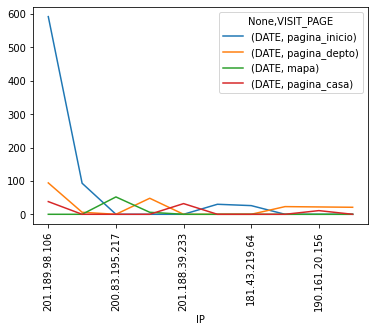

In [123]:
#############################################################
# 5. Análisis exploratorio de datos (tablas, métricas, gráficos, etc).
#############################################################

df_plot.plot()
plt.xticks(rotation='vertical')

In [43]:
grouped.index

MultiIndex([('201.189.98.106', 'pagina_inicio'),
            ('201.189.98.106',  'pagina_depto'),
            ( '190.22.36.168', 'pagina_inicio'),
            ('200.83.195.217',          'mapa'),
            ( '181.43.34.171',  'pagina_depto'),
            ('201.189.98.106',   'pagina_casa'),
            ('201.188.39.233',   'pagina_casa'),
            ('201.241.70.109', 'pagina_inicio'),
            ( '181.43.219.64', 'pagina_inicio'),
            ( '200.120.76.88',  'pagina_depto'),
            ('190.161.20.156',  'pagina_depto'),
            (  '186.11.14.70',  'pagina_depto'),
            ('190.161.20.156',   'pagina_casa'),
            ( '190.22.36.168',  'pagina_depto'),
            ( '181.43.34.171',          'mapa')],
           names=['IP', 'VISIT_PAGE'])

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 <a list of 9 Text major ticklabel objects>)

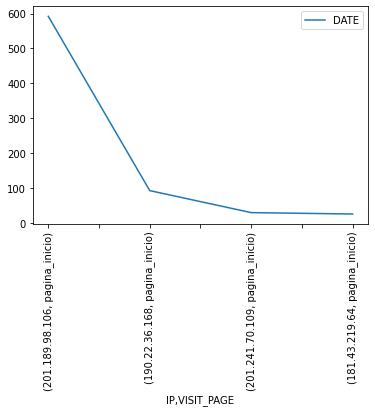

In [13]:
grouped[grouped.index.isin(['pagina_inicio'], level=1)].plot()
plt.xticks(rotation='vertical')

verificamos en que momento se visito el home del sitio por la IP que tiene 592 visitas.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 0, 'Tiempo')

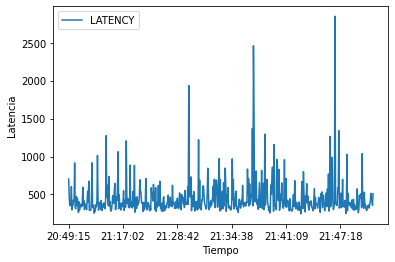

In [139]:
dt_scrapper = data.loc[(data['IP'] == '201.189.98.106') & (data['METHOD'] == 'GET /home/index HTTP/1.0')]
dt_scrapper_lat = dt_scrapper[['DATE', 'LATENCY']]

dt_scrapper_lat['TIME'] = pd.to_datetime(dt_scrapper_lat['DATE']).dt.strftime('%H:%M:%S')
dt_scrapper_lat = dt_scrapper_lat.sort_values(['LATENCY'], ascending=False)
dt_scrapper_lat = dt_scrapper_lat[['TIME','LATENCY']].groupby(['TIME']).sum().sort_values(['TIME'], ascending=True)

dt_scrapper_lat.plot()

plt.ylabel('Latencia')
plt.xlabel('Tiempo')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


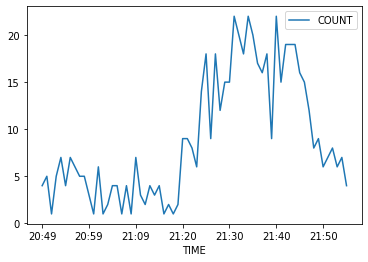

In [135]:
dt_scrapper['TIME'] = pd.to_datetime(dt_scrapper['DATE']).dt.strftime('%H:%M')
dt_scrapper_home =  dt_scrapper[['TIME', 'DATE']]

dt_scrapper_home = {'TIME': dt_scrapper['TIME'] , 
        'COUNT':dt_scrapper['DATE']} 
dt_scrapper_home = pd.DataFrame(dt_scrapper_home)

dt_scrapper_home = dt_scrapper_home.groupby(['TIME']).count().sort_values(['TIME'], ascending=True)

dt_scrapper_home.plot()

Buscamos si alguna vez se logeo como un usuario (dentro del historial)

In [134]:
data.loc[(data['IP'] == '201.189.98.106') & (data['USER'] != 'anonymus')]


,IP,USER,DATE,METHOD,LATENCY


No se encuentra registrado como un usuario

In [140]:
#############################################################
# 6. Exportar el dataframe modificado en un formato que pueda ser recuperado posteriormente
#############################################################

dt_scrapper_home.to_csv('./ip_scrapper_cantidad_request.csv')
dt_scrapper_lat.to_csv('./ip_scrapper_latencia.csv')

In [141]:
data_cant_req = pd.read_csv('./ip_scrapper_cantidad_request.csv')
data_cant_req.shape

(66, 2)

In [142]:
data_lat = pd.read_csv('./ip_scrapper_latencia.csv')
data_lat.shape

(561, 2)

# Conclusión

Podemos ver que existen al menos un grupo de usuarios maliciosos, que están constantemente haciendo peticiones al servidor.

El usuario o la IP que logramos detectar y que hizo un mal uso fue en el horario de las 21:20 y las 21:50 de la noche. Que además la latencia cada vez iba peor entre ese horario, en consecuencia de ello vemos afectado al resto de los usuarios que sí están navegando el sitio web.

Por lo tanto, podemos decir que si deberíamos bloquear al usuario que además nunca se logeo en el sitio, como para poder determinar si era una corredora de propiedades o una inmobiliaria que son clientes VIP del sitio.

En este análisis sólo se obtuvo información relevante de un usuario malicioso y de tan sólo una página (home) en el cual si se destacó por el resto de los usuario realizando 592 peticiones en un rango corto de tiempo.

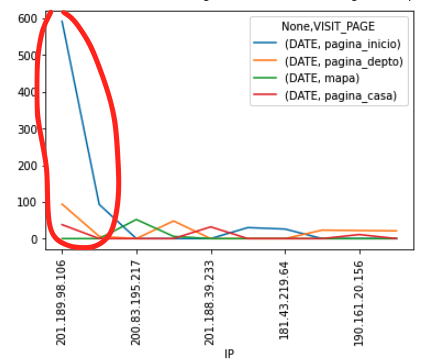

